### Part 2: Outlier, Transformations, Pipelines and Sanity Check

In [1]:
# Import necessary Libraries
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

# The kaggle file is named heart.csv
df_heart = pd.read_csv("../Data_files/heart.csv")
df_heart_encoded = df_heart
df_heart_encoded.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


### Outlier Ditection and Handing

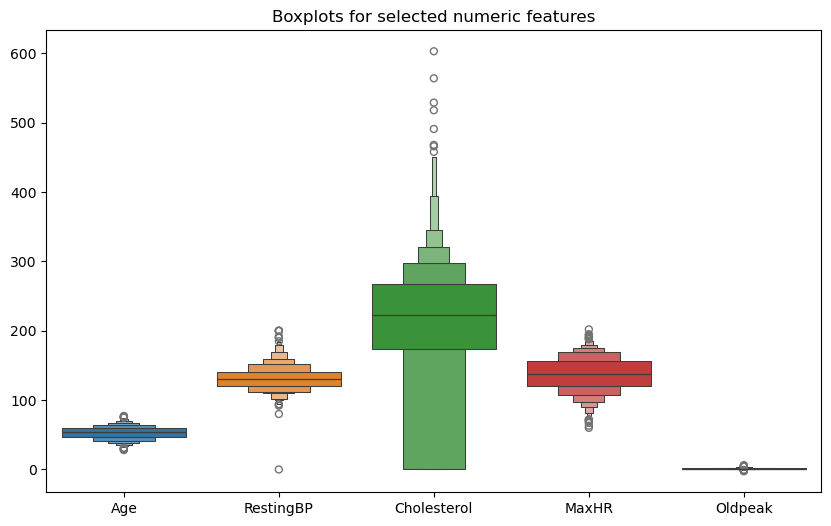

In [2]:
# Visualize some numeric collumns 
numeric_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
plt.figure(figsize=(10,6))
sns.boxenplot(data=df_heart_encoded[numeric_cols])
plt.title("Boxplots for selected numeric features")
plt.show()

In [3]:
# Using IQR method on Cholesterol as an example
col = "Cholesterol"
Q1 = df_heart_encoded[col].quantile(0.25)
Q3 = df_heart_encoded[col].quantile(0.75)
IQR = Q3-Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

outliers = df_heart_encoded[(df_heart_encoded[col] < lower) | (df_heart_encoded[col] > upper)]
print(f"Number of detected outliers in {col}: ", len(outliers))

Number of detected outliers in Cholesterol:  183


In [4]:
# 1. Remove outliers  ### this approach should not be taklen for small dataset, should be avoided in most cases
df_no_outliers = df_heart_encoded[(df_heart_encoded[col] >= lower ) & (df_heart_encoded[col] <= upper)]
print(len(df_no_outliers))

# 2. Cap outliers (winsorization-like approach)   ### this approach doesn't give actual representation of the actual dataset 
df_capped = df_heart_encoded.copy()
df_capped[col] = df_capped[col].clip(lower, upper)
print(len(df_capped))

# Log transform the column (for skewed distribution) ### this approach is better
df_log = df_heart_encoded.copy() 
df_log[col + "_log"] = np.log(df_log[col]+1)
print(df_log)

735
918
     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  Cholesterol_log  
0 

### Feature Transformation and Domain-Driven Features
Real-life analogy: electricity bill categories.

##### Monthly bills: 2400, 2600, 2800, 3000, 9000, 2700. 
##### As raw numbers, it is hard to see a pattern.
##### If we convert them to categories (LOW, MEDIUM, HIGH), it becomes easier to understand behavior.
##### In this section we:

##### Create polynomial features to capture non-linear relationships
##### Use binning to create groups from continuous variables
##### Create domain-driven features such as blood pressure risk levels

In [5]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial features using Age and MaxHR (if available)
poly_cols = ["Age","MaxHR"]
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df_heart_encoded[poly_cols])
poly_features_names = poly.get_feature_names_out(poly_cols)

print(poly_features_names)
print(poly_features.shape)

['Age' 'MaxHR' 'Age^2' 'Age MaxHR' 'MaxHR^2']
(918, 5)


In [6]:
# Bining Age into categories (Young, Middle, Old)
df_heart_encoded["Age_bin"] = pd.cut(
    df_heart_encoded["Age"],
    bins=[0,30,50,70, 100],
    labels=["Young", "Middle", "Adult", "Old"]
)
print(df_heart_encoded[["Age", "Age_bin"]].head(10))

   Age Age_bin
0   40  Middle
1   49  Middle
2   37  Middle
3   48  Middle
4   54   Adult
5   39  Middle
6   45  Middle
7   54   Adult
8   37  Middle
9   48  Middle


In [7]:
# Domain-driven risk categories for RestingBP and Oldpeak
def bp_risk(bp):
    if bp<120:
        return "Normal"
    elif bp<140:
        return "Eleveted"
    else:
        return "High"
def oldpeak_risk(op):
    if op==0:
        return "No Stress"
    elif op<2:
        return "Moderate Stress"
    else:
        return "High Stress"
df_heart_encoded["BP_Risk"] = df_heart_encoded["RestingBP"].apply(bp_risk)
df_heart_encoded["Oldpeak_Risk"] = df_heart_encoded["Oldpeak"].apply(oldpeak_risk)
df_heart_encoded[["RestingBP","BP_Risk","Oldpeak","Oldpeak_Risk"]]

,RestingBP,BP_Risk,Oldpeak,Oldpeak_Risk
0,140,High,0.0,No Stress
1,160,High,1.0,Moderate Stress
2,130,Eleveted,0.0,No Stress
3,138,Eleveted,1.5,Moderate Stress
4,150,High,0.0,No Stress
...,...,...,...,...
913,110,Normal,1.2,Moderate Stress
914,144,High,3.4,High Stress
915,130,Eleveted,1.2,Moderate Stress
916,130,Eleveted,0.0,No Stress


### Putting It All Together in a Preprocessing Pipeline

Real-life analogy: garments factory assembly line.

Cutting → Stitching → Printing → Ironing → Packaging.
Each step must happen in the correct order.
A pipeline in ML ensures preprocessing and modeling steps run in a fixed sequence without mixing training and test data.
We will:

Build separate pipelines for numeric and categorical features
Combine them using ColumnTransformer
Attach a simple model (Logistic Regression) at the end to create a full pipeline.

In [8]:
from sklearn.compose import ColumnTransformer  
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
num_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
cat_features = ["Sex", "ExerciseAngina", "ChestPainType", "RestingECG", "ST_Slope"]

# Numerical Pipeline
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# Categorical Pipeline
cat_pipeline = Pipeline([
    ("one", OneHotEncoder(drop="first"))
])

# Combine both
preprocess = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Full Pipeline with a simple model
clf = Pipeline([
    ("prep", preprocess),  
    ("model", LogisticRegression(max_iter=1000))
])

### Quick Sanity Check with a Simple Model

Real-life analogy: test-driving a car before buying it.

You do not buy a car based only on brochures.
You take it for a test drive to see if everything works as expected.
Similarly, before building complex models, we run a simple model (e.g., Logistic Regression) with our preprocessing pipeline to ensure:

The pipeline runs without errors
There is no data leakage
The accuracy is reasonable for a first attempt
This is not the final model, just a sanity check.

In [11]:
# Train-Test split using original df_heart (not already encoded)
target_col = "HeartDisease"
X = df_heart.drop(columns=[target_col])
y = df_heart[target_col]

X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(
    X, y, test_size=0.25, random_state = 42
)

# Fit the pipeline
clf.fit(X_train_pipe, y_train_pipe)

# Predict and evaluate
from sklearn.metrics import accuracy_score
y_pred_pipe = clf.predict(X_test_pipe) 
acc = accuracy_score(y_test_pipe, y_pred_pipe)
print("Logistic Regression with preprocessing pipeline: ", acc)

Logistic Regression with preprocessing pipeline:  0.8434782608695652
